In [ ]:
# Very long ~20 mins
# Runtime restarts after install

!pip install -q poetry
!poetry config virtualenvs.create false
!poetry env use 3.11.13
!poetry init --no-interaction
!poetry add torch torchmetrics torchinfo torchview torchvision\
 onnx==1.14.0 onnxruntime onnx-tf\
 tensorflow==2.15 tensorflow-probability==0.23.0 tflite-runtime keras==2.15 --python 3.11

import os
os.kill(os.getpid(), 9)

Skipping virtualenv creation, as specified in config file.

[Errno 2] No such file or directory: '/root/.cache/pypoetry/virtualenvs/envs.toml'
A pyproject.toml file with a project and/or a poetry section already exists.
Skipping virtualenv creation, as specified in config file.
The following packages are already present in the pyproject.toml and will be skipped:

  - torch
  - torchmetrics
  - torchinfo
  - torchview
  - torchvision
  - onnxruntime
  - onnx-tf
  - tflite-runtime

If you want to update it to the latest compatible version, you can use `poetry update package`.
If you prefer to upgrade it to the latest available version, you can use `poetry add package@latest`.


Updating dependencies
Resolving dependencies... (0.3s)

No dependencies to install or update


In [ ]:
#@title General purpose (train)
import torch
from torch import nn

def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device):
  """Performs a training with model trying to learn on data_loader"""
  train_loss, train_acc = 0, 0
  model.train()
  for batch, (X, y) in enumerate(data_loader):
    X, y = X.to(device), y.to(device)
    y_pred = model(X)
    loss = loss_fn(y_pred, y)
    acc = accuracy_fn(y, y_pred.argmax(dim=1))
    train_loss += loss
    train_acc += acc
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  #print(f"Train loss: {train_loss:.5f} | Train acc: {train_acc:.2f}")
  return train_loss, train_acc

def test_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device: torch.device):
  """Performs a testing with model"""
  test_loss, test_acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for (X, y) in data_loader:
      X, y = X.to(device), y.to(device)
      test_pred = model(X)
      test_loss += loss_fn(test_pred, y)
      test_acc += accuracy_fn(y, test_pred.argmax(dim=1))

    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    #print(f"Test loss: {test_loss:.5f} | Test acc: {test_acc:.2f}\n")
  return test_loss, test_acc

def model_estim(model, epochs, train_dataloader, test_dataloader, loss_fn, optimizer, accuracy_fn, device):
  train_losses, test_losses = [], []
  train_accs, test_accs = [], []

  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model=model,
              data_loader=train_dataloader,
              loss_fn=loss_fn,
              optimizer=optimizer,
              accuracy_fn=accuracy_fn,
              device=device)
    test_loss, test_acc = test_step(model=model,
              data_loader=test_dataloader,
              loss_fn=loss_fn,
              accuracy_fn=accuracy_fn,
              device=device)
    train_losses.append(train_loss.detach().cpu())
    test_losses.append(test_loss.detach().cpu())
    train_accs.append(train_acc.detach().cpu())
    test_accs.append(test_acc.detach().cpu())
  return train_losses, test_losses, train_accs, test_accs

from timeit import default_timer as timer
def train_model(model, epochs, train_dataloader, test_dataloader, loss_fn, optimizer, accuracy_fn, device):
  start_time = timer()
  train_losses, test_losses, train_accs, test_accs = model_estim(model=model,
                                                                 epochs=epochs,
                                                                 train_dataloader=train_dataloader,
                                                                 test_dataloader=test_dataloader,
                                                                 loss_fn=loss_fn,
                                                                 optimizer=optimizer,
                                                                 accuracy_fn=accuracy_fn,
                                                                 device=device)

  end_time = timer()
  total_training_time_model_1 = print(f"\nTrain time on {device}: {(end_time - start_time):.3f} seconds")

  epochs_ = np.array(range(epochs))
  fig, axes = plt.subplots(1, 2, figsize=(12, 5))

  axes[0].plot(epochs_, np.array(train_losses), label="train", color="red")
  axes[0].plot(epochs_, np.array(test_losses), label="test", color="blue")
  axes[0].set_title('Train and test loss')
  axes[0].set_xlabel('Epoch')
  axes[0].set_ylabel('Loss')
  axes[0].set_xticks(epochs_)
  axes[0].legend()

  axes[1].plot(epochs_, np.array(train_accs), label="train", color="red")
  axes[1].plot(epochs_, np.array(test_accs), label="test", color="blue")
  axes[1].set_title('Train and test accuracy')
  axes[1].set_xlabel('Epoch')
  axes[1].set_ylabel('Loss')
  axes[1].set_xticks(epochs_)
  axes[1].legend()
  plt.show()
  torch.save(obj=model_1.state_dict(), f='EMNIST_recognition.pth')


In [ ]:
#@title General purpose (visualisation, save, load)
import numpy as np
import torch
from torchmetrics import ConfusionMatrix
import matplotlib.pyplot as plt
import torch.nn as nn
import onnx
from onnx_tf.backend import prepare
import tensorflow as tf
from torchvision import datasets
from torchvision.transforms import ToTensor


def get_conf_mat_torch(model_):
  y_preds = []
  model_.eval()
  with torch.inference_mode():
    for X,y in test_dataloader:
      X,y = X.to(device), y.to(device)
      y_logit = model_(X)
      y_pred = y_logit.argmax(dim=1)
      y_preds.append(y_pred.cpu())

  y_pred_tensor = torch.cat(y_preds)
  return y_pred_tensor

def get_conf_mat_onnx(ort_session):
  y_preds = []
  for X, y in test_dataloader:
      X_np = X.numpy() if isinstance(X, torch.Tensor) else X
      input_name = ort_session.get_inputs()[0].name
      outputs = ort_session.run(None, {input_name: X_np})
      y_pred = outputs[0].argmax(axis=1)
      y_preds.append(torch.tensor(y_pred))

  y_pred_tensor = torch.cat(y_preds)
  return y_pred_tensor

def get_conf_mat_tflite(interpreter):
  y_preds = []
  input_details = interpreter.get_input_details()
  output_details = interpreter.get_output_details()
  scale, zero_point = input_details[0]['quantization']
  dtype = input_details[0]['dtype']

  for X, y in test_dataloader:
      X_np = X.numpy()
      X_q = X_np / scale + zero_point
      X_q = np.clip(X_q, np.iinfo(dtype).min, np.iinfo(dtype).max)
      X_q = X_q.astype(dtype)

      interpreter.resize_tensor_input(input_details[0]['index'], X_q.shape)
      interpreter.allocate_tensors()

      interpreter.set_tensor(input_details[0]['index'], X_q)
      interpreter.invoke()
      output_data = interpreter.get_tensor(output_details[0]['index'])

      out_scale, out_zero = output_details[0]['quantization']
      output_data = (output_data.astype(np.float32) - out_zero) * out_scale

      y_pred = np.argmax(output_data, axis=1)
      y_preds.append(torch.tensor(y_pred))

  y_pred_tensor = torch.cat(y_preds)

  return y_pred_tensor

def print_metrics(class_names, y_pred_tensor):
  from torchmetrics.classification import MulticlassAccuracy, MulticlassPrecision, MulticlassRecall, MulticlassF1Score
  num_classes = len(class_names)
  accuracy = MulticlassAccuracy(num_classes=num_classes)
  precision = MulticlassPrecision(num_classes=num_classes, average='macro')
  recall = MulticlassRecall(num_classes=num_classes, average='macro')
  f1 = MulticlassF1Score(num_classes=num_classes, average='macro')

  acc_value = accuracy(y_pred_tensor, test_data.targets)
  prec_value = precision(y_pred_tensor, test_data.targets)
  rec_value = recall(y_pred_tensor, test_data.targets)
  f1_value = f1(y_pred_tensor, test_data.targets)

  print(f"Accuracy:  {acc_value:.4f}")
  print(f"Precision: {prec_value:.4f}")
  print(f"Recall:    {rec_value:.4f}")
  print(f"F1-score:  {f1_value:.4f}")

def draw_conf_tensor(confmat_tensor):
  plt.figure(figsize=(8, 6))
  plt.imshow(confmat_tensor.numpy(), cmap='viridis', interpolation='nearest', )
  plt.colorbar()  # Add a color bar
  plt.title('Confusion matrix')
  plt.xlabel('predicted')
  plt.ylabel('true')
  plt.xticks(ticks=range(len(class_names)), labels=class_names)
  plt.yticks(ticks=range(len(class_names)), labels=class_names)
  plt.show()

def save_to_onnx(model, filename, device):
  dummy_input = torch.randn(1, 1, 28, 28) # see test_data

  model.to('cpu').eval()
  torch.onnx.export(
    model,
    dummy_input,
    filename,
    input_names=["input"],
    output_names=["output"],
    dynamic_axes={
        "input": {0: "batch_size"},   # dynamic batch size
        "output": {0: "batch_size"}
    },
    do_constant_folding=True,
    dynamo=False, # old exporter, new crashes and buggy
    opset_version=11  # some layers may need >= 11
  )
  model.to(device)

def onnx_to_tflite(onnx_name, train_data):
  onnx_model = onnx.load(onnx_name)
  tf_rep = prepare(onnx_model)
  tf_rep.export_graph("model_tf")
  print("✅ Converted to TensorFlow")

  def representative_data_gen():
    for i, (x, _) in enumerate(train_data):
      if i > 200:  # 200 samples is enough
        break
      yield [x.unsqueeze(0).numpy()]

  # TensorFlow → TFLite
  converter = tf.lite.TFLiteConverter.from_saved_model("model_tf")
  converter.optimizations = [tf.lite.Optimize.DEFAULT]
  converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
  converter.representative_dataset = representative_data_gen
  converter.inference_input_type = tf.int8
  converter.inference_output_type = tf.int8

  tflite_model = converter.convert()
  with open("my_lenet.tflite", "wb") as f:
      f.write(tflite_model)
  print("✅ Converted to model.tflite")

/usr/local/lib/python3.11/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


#LeNet Example

100%|██████████| 562M/562M [00:05<00:00, 109MB/s]


Train casses : 697932 
Test cases: 116323 
Labels: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'd', 'e', 'f', 'g', 'h', 'n', 'q', 'r', 't']
DataLoaders: (<torch.utils.data.dataloader.DataLoader object at 0x7d8467029a10>, <torch.utils.data.dataloader.DataLoader object at 0x7d846702a510>)
Length of train_dataloader 21811 batches of 32...
Length of test_dataloader 3636 batches of 32...


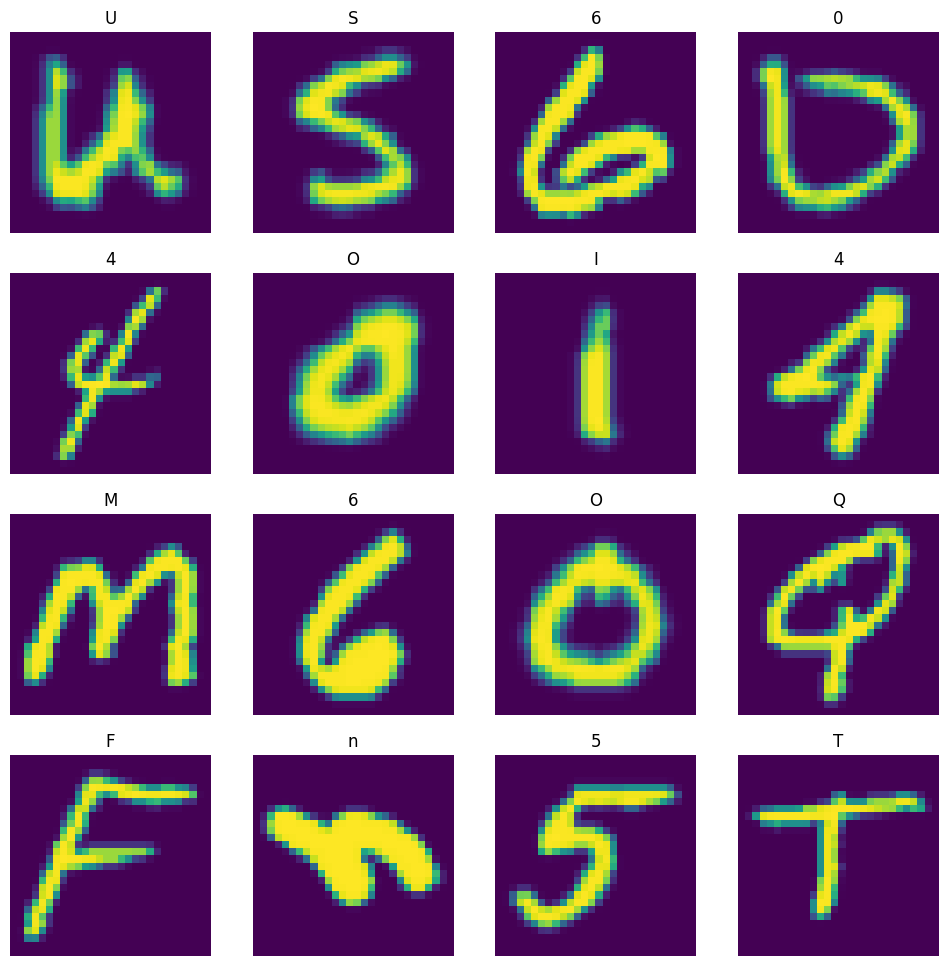

In [ ]:
#@title Load Dataset

import os
import torch
from torch import nn
import torchvision
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from timeit import default_timer as timer
import torchmetrics, mlxtend
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix
from tqdm.auto import tqdm
import random
import pandas as pd
import matplotlib.pyplot as plt
from torchmetrics import Accuracy
from torchinfo import summary
import numpy as np

from google.colab import output
output.clear()

train_data = datasets.EMNIST(
    root="data",
    split="bymerge",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

test_data = datasets.EMNIST(
    root="data",
    split="bymerge",
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

class_names = train_data.classes
num_classes = len(class_names)
print(f"Train casses : {len(train_data)} \nTest cases: {len(test_data)} \nLabels: {class_names}" )

torch.manual_seed(42)
fig = plt.figure(figsize=(12,12))
rows, cols = 4, 4
for i in range(1, rows*cols+1):
  random_idx = torch.randint(0, len(train_data), size=[1]).item()
  img, label = train_data[random_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(img.squeeze().T)
  plt.title(class_names[label])
  plt.axis(False)

BATCH_SIZE = 32

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=os.cpu_count())

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False,
                             num_workers=os.cpu_count())

print(f"DataLoaders: {train_dataloader, test_dataloader}")
print(f"Length of train_dataloader {len(train_dataloader)} batches of {BATCH_SIZE}...")
print(f"Length of test_dataloader {len(test_dataloader)} batches of {BATCH_SIZE}...")

device = "cuda" if torch.cuda.is_available() else "cpu"

* Convolution
$$
\mathbf{Y} = \text{Conv}_{\mathbf{w}}(\mathbf{X}); \quad
Y_{i,j} = \sum_{\alpha=-1}^1 \sum_{\beta=-1}^1 X_{i+\alpha, j+\beta} w_{\alpha,\beta}
$$
* ReLU
$$
\mathbf{Y} = \text{ReLU}(\mathbf{X}); \quad
Y_{i,j} = X_{i,j} \Theta(X_{i,j}),
$$
where $\Theta$ is the Heaviside function
* MaxPool
$$
\mathbf{Y} = \text{MaxPool}(\mathbf{X}); \quad
Y_{i,j} = \max\{X_{2i,2j};X_{2i+1,2j};X_{2i,2j+1};X_{2i+1,2j+1}\}
$$
please note that in this case matrix $\mathbf{Y}$ has different size.
* Fully connected
$$
\vec{Y} = \text{Linear}_{\mathbf{w}}(\mathbf{X}); \quad
Y_i = \sum_{i,j} X_{i,j} w_{i,j}
$$
<br><br><br>
The whole neural network can be written down as
$$
\vec{Y} = \underbrace{\text{Linear}_{\mathbf{w''}}(\text{MaxPool}(\text{ReLU}(\text{Conv}_{\mathbf{w'}}(\text{ReLU}(\text{Conv}_{\mathbf{w}}(\mathbf{X}))))))}_{\text{Neural Network}}
$$

In [ ]:
import torch
from torch import nn

class ConvolutionEMNISTModel(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()
    self.layer_stack = nn.Sequential(
      nn.Conv2d(in_channels=input_shape,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1),
      nn.ReLU(),
      nn.Conv2d(in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2),
      nn.Flatten(),
      nn.LazyLinear(out_features=output_shape)
      )

  def forward(self, x):
    return self.layer_stack(x)

device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
#@title Model
torch.manual_seed(42)
model_1 = ConvolutionEMNISTModel(input_shape=1,
                              hidden_units=10,
                              output_shape=len(class_names)).to(device)

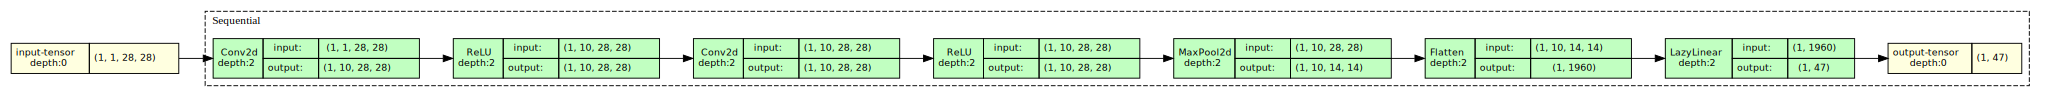

In [ ]:
#@title NN Structure

from torchview import draw_graph
model_graph = draw_graph(model_1, input_size=[1,1,28,28], expand_nested=True, graph_dir='LR',)
model_graph.resize_graph(scale=5.0)
model_graph.visual_graph

**Categorical cross-entropy** loss function $L$ is computed as follows
$$
L = - \sum_i t_i \ln(\sigma_i),
$$
where $t_i$ are truth values and $\sigma_i$ are **softmax** outputs
$$
\sigma_i(\mathbf{z}) = \frac{e^{z_i}}{\sum_{j=1}^K e^{z_j}} \text{ for } i = 1, \dotsc, K \text{ and } \mathbf{z} = (z_1, \dotsc, z_K) \in \mathbb{R}^K.
$$
In our case $t_i$ are either $0$ or $1$ (see `to_categorical` function). We may have used `sparse_crossentropy`, same function different class encoding.

  0%|          | 0/3 [00:00<?, ?it/s]


Train time on cuda: 570.452 seconds


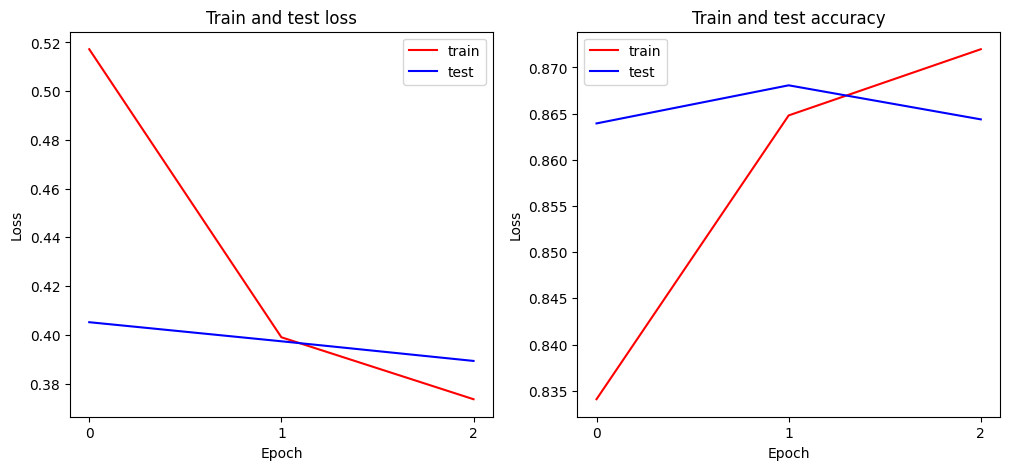

In [ ]:
#@title Train (very slow, better load pretrained)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.1)
accuracy_fn = Accuracy(task="multiclass", num_classes=num_classes).to(device)


train_model(model=model_1,
            epochs=3,
            train_dataloader=train_dataloader,
            test_dataloader=test_dataloader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            accuracy_fn=accuracy_fn,
            device=device)

In [ ]:
#@title Preload
!wget https://raw.githubusercontent.com/fbeilstein/presentations/refs/heads/master/presentation_for_December_3_2024/EMNIST_recognition.pth
model_1.load_state_dict(torch.load('EMNIST_recognition.pth', map_location=torch.device(device)))

--2025-10-16 12:22:14--  https://raw.githubusercontent.com/fbeilstein/presentations/refs/heads/master/presentation_for_December_3_2024/EMNIST_recognition.pth
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 375542 (367K) [application/octet-stream]
Saving to: ‘EMNIST_recognition.pth’

EMNIST_recognition. 100%[===================>] 366.74K  --.-KB/s    in 0.01s   

2025-10-16 12:22:15 (29.8 MB/s) - ‘EMNIST_recognition.pth’ saved [375542/375542]



<All keys matched successfully>

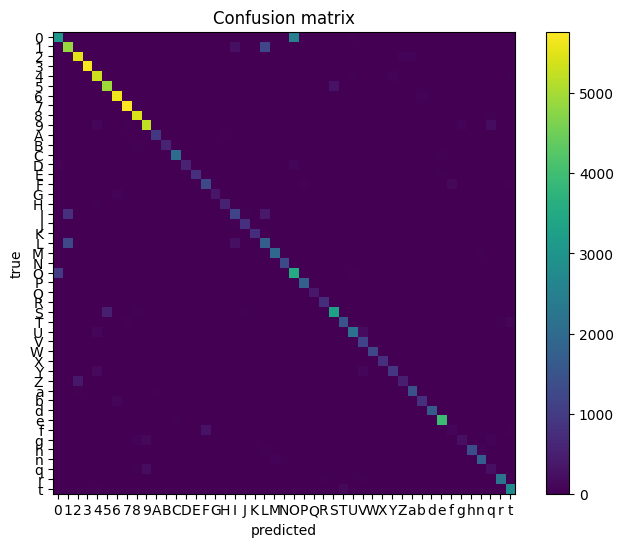

Accuracy:  0.8342
Precision: 0.8546
Recall:    0.8342
F1-score:  0.8403


In [ ]:
#@title Quality

y_pred_tensor = get_conf_mat_torch(model_1)
confmat = ConfusionMatrix(task='multiclass', num_classes=len(class_names))
confmat_tensor = confmat(preds=y_pred_tensor,
                        target=test_data.targets)
draw_conf_tensor(confmat_tensor)
print_metrics(class_names, y_pred_tensor)

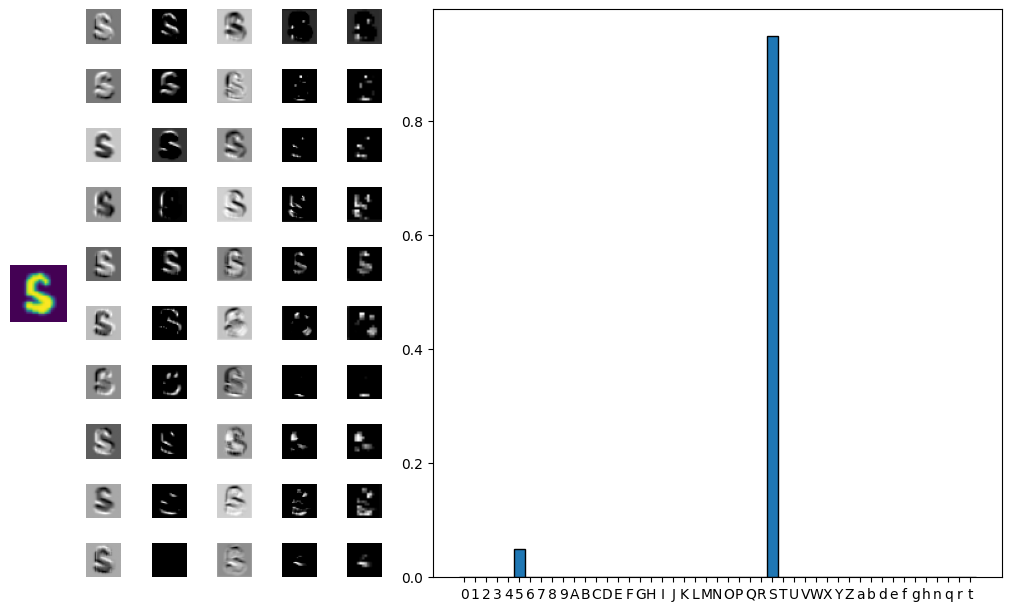

In [ ]:
#@title Internal Structure
max_idx = len(test_data)
cur_idx = 0


from IPython.display import display
import ipywidgets as widgets
from IPython.display import clear_output

def plot_out(idx):
  image, img_class = test_data[idx]
  model_1.eval()
  #image = np.transpose(image, (0,2,1))
  x = image.unsqueeze(0).to(device)
  fig = plt.figure(figsize=(10,6), constrained_layout=True)
  grid = plt.GridSpec(10, 7, wspace=0, hspace=0, figure=fig,
                      width_ratios=[1,1,1,1,1,1,10],
                      height_ratios=[1,1,1,1,1,1,1,1,1,1])
  ax_input = plt.subplot(grid[:,0], xticks=[], yticks=[])
  ax_input.imshow(image[0].T)
  ax_input.axis(False)
  with torch.inference_mode():
    for i, layer in enumerate(model_1.layer_stack):
      x = layer(x)
      for j, xx in enumerate(x[0]):
        numpy_img = xx.cpu().detach().numpy()
        if numpy_img.ndim != 2: continue
        plt.subplot(grid[j,i+1], xticks=[], yticks=[])
        plt.imshow(numpy_img.T, cmap="grey")
        plt.axis(False)
  bin_edges = [x - 0.5 for x in range(48)]
  bar_heights = torch.softmax(x.squeeze(), dim=0).detach().cpu().numpy()
  bar_widths = [1] * 47
  ax_result = plt.subplot(grid[:,6])#, xticks=class_names)
  ax_result.bar(bin_edges[:-1], bar_heights, width=bar_widths, align='edge', edgecolor='black')
  ax_result.set_xticks(ticks=list(range(len(class_names))), labels=class_names)
  #ax_result.xlabel('Numbers')
  #ax_result.ylabel('Probabilities')
  plt.show()

def clear_show_widgets():
  clear_output()
  buttonN = widgets.Button(description="Next")
  buttonP = widgets.Button(description="Previous")
  display(widgets.HBox([buttonN, buttonP]))
  buttonN.on_click(on_button_clicked_next)
  buttonP.on_click(on_button_clicked_previous)

def on_button_clicked_next(*args):
  global cur_idx
  cur_idx = (1 + cur_idx) % max_idx
  clear_show_widgets()
  plot_out(cur_idx)

def on_button_clicked_previous(*args):
  global cur_idx
  cur_idx = (cur_idx - 1 + max_idx) % max_idx
  clear_show_widgets()
  plot_out(cur_idx)


clear_show_widgets()


In [ ]:
#@title #Visualization code
import IPython
from google.colab import output
import numpy as np
import json

def process_symbol(num_img):
  #num_img = center_image(num_img)
  #img = torch.tensor(num_img, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
  x = torch.tensor(num_img.T, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
  model_1.eval()
  #plt.figure(figsize=(15,10))
  with torch.inference_mode():
    for i, layer in enumerate(model_1.layer_stack):
      x = layer(x)
      for j, xx in enumerate(x[0]):
        numpy_img = xx.cpu().detach().numpy()
        if numpy_img.ndim != 2: continue
        #plt.subplot(10, 10, 10*j+i+1)
        #plt.imshow(numpy_img)
        #plt.title(type(layer).__name__, fontsize=8)
        #plt.axis(False)
  #plt.show()
  return x.argmax(dim=1).cpu().item()


def do_recognition(array_8x8):
  arr = np.transpose(np.array(array_8x8))
  return IPython.display.JSON({'msg': process_symbol(arr)})

main_str = '''
<body>
  	<div id="paint">
  		<canvas id="myCanvas" width="600" height="600"
              onmousedown="start_paint(event)"
              onmousemove="do_paint(event)"
              onmouseup="stop_paint(event)"
              style="border:3px solid #000000;">
      </canvas>
	  </div>
    <div style="position:absolute; top:0px; left:625px;">
        <h2> Cropped image </h2>
        <img id="partial_image" style="width:80px; height:80px; border:3px solid #000000;">
        <h2> Scaled </h2>
        <canvas id="bin_canvas" width="80" height="80"
              style="border:3px solid #000000;">
        </canvas>
        <h2> Recognize symbol </h2>
        <button type="button" onclick="process_data();">
        Do recognition
        </button>
        <h2> Clean canvas </h2>
        <button type="button" onclick="clear_canvas();">
        Clean
        </button>
        <h2> Recognition result </h2>
        <div id="rec_res" style="font-size:40px;"></div>
    </div>
<script>

var canvas = document.getElementById('myCanvas');
var ctx = canvas.getContext('2d');
var canvas_2 = document.getElementById("bin_canvas");
var ctx_2 = canvas_2.getContext("2d");
var mouse = {x: 0, y: 0, state: 0, min_x: 600, max_x: 0, min_y: 600, max_y: 0};
var full_image = ctx.getImageData(0, 0, 600, 600);
var partial_image = document.getElementById('partial_image');
var binarized = null;

var N_scaled = 28;

ctx.lineJoin = 'round';
ctx.lineCap = 'round';


function start_paint(e)
{
  ctx.putImageData(full_image, 0, 0);
  mouse.state = 1;
  ctx.beginPath();
  ctx.moveTo(mouse.x, mouse.y);
}

var line_width = 35;//28;

function do_paint(e)
{
  mouse.x = e.pageX - 10;
  mouse.y = e.pageY - 10;
  if (!mouse.state)
    return;
  ctx.lineTo(mouse.x, mouse.y);
  ctx.lineWidth = line_width;
  ctx.strokeStyle = '#000000';
  ctx.stroke();
  full_image = ctx.getImageData(0, 0, 600, 600);
  if (mouse.min_x > mouse.x)
    mouse.min_x = mouse.x;
  if (mouse.min_y > mouse.y)
    mouse.min_y = mouse.y;
  if (mouse.max_x < mouse.x)
    mouse.max_x = mouse.x;
  if (mouse.max_y < mouse.y)
    mouse.max_y = mouse.y;
}

function stop_paint(e)
{
  mouse.state = 0;
  full_image = ctx.getImageData(0, 0, 600, 600);

  c_x = (mouse.max_x + mouse.min_x) / 2;
  c_y = (mouse.max_y + mouse.min_y) / 2;
  a = Math.max(mouse.max_x - mouse.min_x, mouse.max_y - mouse.min_y);
  a += line_width;// + 90;
  var part = ctx.getImageData(c_x - a/2, c_y - a/2, a, a);
  partial_image.src = getImageURL(part);

  binarized = Array(N_scaled).fill(0).map(x => Array(N_scaled).fill(0))
  var counts = Array(N_scaled).fill(0).map(x => Array(N_scaled).fill(0))

  for (var idx_y = 0; idx_y < part.height; idx_y += 1)
    for (var idx_x = 0; idx_x < part.width; idx_x += 1)
    {
      counts[Math.floor(N_scaled * idx_x / part.width)][Math.floor(N_scaled * idx_y / part.height)] += 1;
      if (part.data[idx_y * part.width * 4 + idx_x * 4 + 3] > 1)
      	binarized[Math.floor(N_scaled * idx_x / part.width)][Math.floor(N_scaled * idx_y / part.height)] += 1;
    }

  for (var i = 0; i < N_scaled; i++)
    for (var j = 0; j < N_scaled; j++)
      binarized[i][j] = binarized[i][j] / counts[i][j];

  ctx_2.fillStyle = "rgba(255, 255, 255, 255)";
  ctx_2.fillRect(0, 0, canvas_2.width, canvas_2.height);
  for (var i = 0; i < N_scaled; i++)
    for (var j = 0; j < N_scaled; j++)
    {
      var c = Math.floor(255 - 255*binarized[i][j]);
      var x = Math.floor(canvas_2.width / N_scaled * i);
      var y = Math.floor(canvas_2.height / N_scaled * j);
      var dx = Math.floor(canvas_2.width / N_scaled + 1);
      var dy = Math.floor(canvas_2.height / N_scaled + 1);
      ctx_2.fillStyle = "rgba(" + [c, c, c, 255].join(",") + ")";
      ctx_2.fillRect(x, y, dx, dy);
    }

  ctx.lineWidth = 2;
  ctx.strokeStyle = '#FF0000';
  ctx.strokeRect(c_x - a/2, c_y - a/2, a, a);
}

function getImageURL(imgData)
{
   var canvas = document.createElement('canvas');
   var ctx = canvas.getContext('2d');
   canvas.width = imgData.width;
   canvas.height = imgData.height;
   ctx.putImageData(imgData, 0, 0);
   return canvas.toDataURL(); //image URL
}

async function process_data()
{
  const result = await google.colab.kernel.invokeFunction('notebook.DoRec', [binarized], {});
  params = result.data['application/json'];
  document.getElementById('rec_res').innerHTML = "0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabdefghnqrt"[params.msg];
}

function clear_canvas()
{
  mouse = {x: 0, y: 0, state: 0, min_x: 600, max_x: 0, min_y: 600, max_y: 0};
  binarized = null;
  ctx.clearRect(0, 0, canvas.width, canvas.height);
  full_image = ctx.getImageData(0, 0, 600, 600);
  ctx_2.clearRect(0, 0, 80, 80);
  var part = ctx.getImageData(0, 0, 80, 80);
  partial_image.src = getImageURL(part);
  document.getElementById('rec_res').innerHTML = "";
}

    </script>
  </body>
'''

display(IPython.display.HTML(main_str))
output.register_callback('notebook.DoRec', do_recognition)

In [ ]:
#@title Structured pruning

import torch
import torch.nn.utils.prune as prune
import torch.nn as nn

def prune_all_conv_layers(model, amount=0.2):
    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d):
            prune.ln_structured(module, name='weight', amount=amount, n=2, dim=0)
            prune.remove(module, 'weight')
            print(f"Pruned {amount*100}% of filters in layer: {name}")

prune_all_conv_layers(model_1, amount=0.2)



In [ ]:
#@title Quality

y_pred_tensor = get_conf_mat_torch(model_1)
confmat = ConfusionMatrix(task='multiclass', num_classes=len(class_names))
confmat_tensor = confmat(preds=y_pred_tensor,
                        target=test_data.targets)
draw_conf_tensor(confmat_tensor)
print_metrics(class_names, y_pred_tensor)

#Model saving / loading

In [ ]:
#@title Save model to onnx

save_to_onnx(model_1, "my_lenet.onnx", device)

/tmp/ipython-input-2-68059806.py:102: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(


In [ ]:
#@title Load onnx model
import onnx
import onnxruntime as ort

ort_session = ort.InferenceSession("my_lenet.onnx")

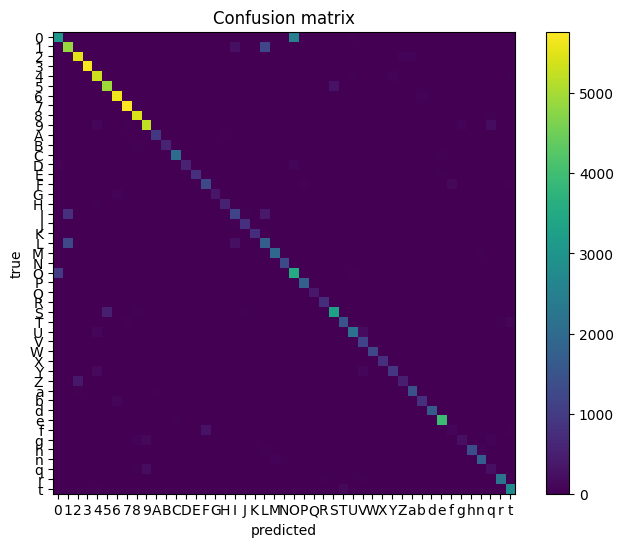

Accuracy:  0.8342
Precision: 0.8546
Recall:    0.8342
F1-score:  0.8403


In [ ]:
#@title Quality

y_pred_tensor = get_conf_mat_onnx(ort_session)
confmat = ConfusionMatrix( task='multiclass', num_classes=len(class_names))
confmat_tensor = confmat(preds=y_pred_tensor,
                        target=test_data.targets)
draw_conf_tensor(confmat_tensor)
print_metrics(class_names, y_pred_tensor)

#Quantization

In [ ]:
#@title Save quantize model to tflite

onnx_to_tflite("my_lenet.onnx", train_data)

INFO:absl:Function `__call__` contains input name(s) x with unsupported characters which will be renamed to transpose_8_x in the SavedModel.
INFO:absl:Found untraced functions such as gen_tensor_dict while saving (showing 1 of 1). These functions will not be directly callable after loading.
INFO:absl:Writing fingerprint to model_tf/fingerprint.pb


✅ Converted to TensorFlow
✅ Converted to model.tflite


In [ ]:
#@title Load quantized model from tflite
import tensorflow as tf

interpreter = tf.lite.Interpreter(model_path="my_lenet.tflite")
interpreter.allocate_tensors()

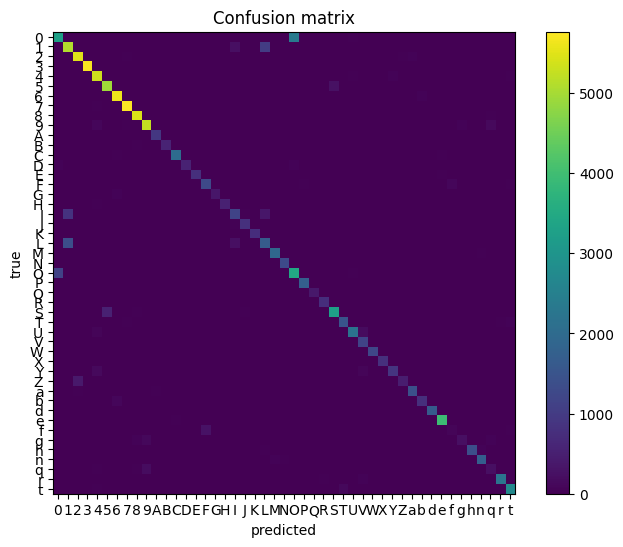

Accuracy:  0.8324
Precision: 0.8565
Recall:    0.8324
F1-score:  0.8400


In [ ]:
#@title Quality

import numpy as np
import torch
from torchmetrics import ConfusionMatrix
import matplotlib.pyplot as plt

y_pred_tensor = get_conf_mat_tflite(interpreter)
confmat = ConfusionMatrix( task='multiclass', num_classes=len(class_names))
confmat_tensor = confmat(preds=y_pred_tensor,
                        target=test_data.targets)

draw_conf_tensor(confmat_tensor)
print_metrics(class_names, y_pred_tensor)

#Knowledge distillation

In [ ]:
#@title Student model
import torch.nn.functional as F

class MLPStudent(nn.Module):
    def __init__(self, num_classes=47):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # flatten
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

student = MLPStudent().to(device)

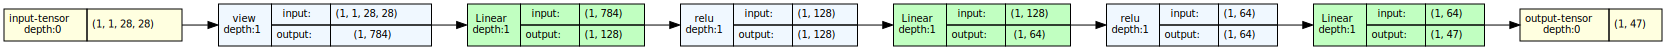

In [ ]:
#@title Student model structure

from torchview import draw_graph
model_graph = draw_graph(student, input_size=[1,1,28,28], expand_nested=True, graph_dir='LR',)
model_graph.resize_graph(scale=5.0)
model_graph.visual_graph



In [ ]:
#@title Knowledge distillation / training (long)

import torch
import torch.nn.functional as F
from tqdm import tqdm

teacher = model_1
optimizer = torch.optim.Adam(student.parameters(), lr=1e-3)

def cross_entropy_loss(student_logits, labels):
    return F.cross_entropy(student_logits, labels)

def kl_divergence_loss(student_logits, teacher_logits, T=4.0):
    soft_teacher = F.softmax(teacher_logits / T, dim=1)
    soft_student = F.log_softmax(student_logits / T, dim=1)
    return F.kl_div(soft_student, soft_teacher, reduction='batchmean') * (T * T)

def distillation_loss(student_logits, teacher_logits, labels, alpha=0.7, T=4.0):
    loss_ce = cross_entropy_loss(student_logits, labels)
    loss_kl = kl_divergence_loss(student_logits, teacher_logits, T)
    loss = alpha * loss_ce + (1 - alpha) * loss_kl
    return loss, loss_ce, loss_kl

def train_epoch_distill(student, teacher, dataloader, optimizer, device,
                        alpha=0.7, T=4.0):
    teacher.eval()
    student.train()

    total_loss, total_ce, total_kl = 0.0, 0.0, 0.0
    total_correct, total_samples = 0, 0

    for images, labels in tqdm(dataloader, desc="Training"):
        images, labels = images.to(device), labels.to(device)

        with torch.no_grad():
            teacher_logits = teacher(images)

        student_logits = student(images)

        loss, loss_ce, loss_kl = distillation_loss(
            student_logits, teacher_logits, labels, alpha, T
        )

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * images.size(0)
        total_ce += loss_ce.item() * images.size(0)
        total_kl += loss_kl.item() * images.size(0)

        preds = student_logits.argmax(dim=1)
        total_correct += (preds == labels).sum().item()
        total_samples += labels.size(0)

    avg_loss = total_loss / total_samples
    avg_ce = total_ce / total_samples
    avg_kl = total_kl / total_samples
    acc = total_correct / total_samples

    return {
        "loss": avg_loss,
        "ce_loss": avg_ce,
        "kl_loss": avg_kl,
        "acc": acc
    }

for epoch in range(2):
    stats = train_epoch_distill(student, teacher, train_dataloader, optimizer, device,
                                alpha=0.7, T=4.0)
    print(f"Epoch {epoch+1}: "
          f"loss={stats['loss']:.4f}, acc={stats['acc']:.4f}, "
          f"CE={stats['ce_loss']:.4f}, KL={stats['kl_loss']:.4f}")



Training: 100%|██████████| 21811/21811 [02:53<00:00, 125.68it/s]


Epoch 1: loss=0.9567, acc=0.8225, CE=0.5488, KL=1.9085


Training: 100%|██████████| 21811/21811 [02:50<00:00, 127.99it/s]

Epoch 2: loss=0.6207, acc=0.8608, CE=0.4079, KL=1.1174


In [ ]:
#@title Save student model to onnx
save_to_onnx(student, "student.onnx")

/tmp/ipython-input-2-68059806.py:102: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(


In [ ]:
#@title Load student model from onnx

import onnx
import onnxruntime as ort

ort_session = ort.InferenceSession("student.onnx")

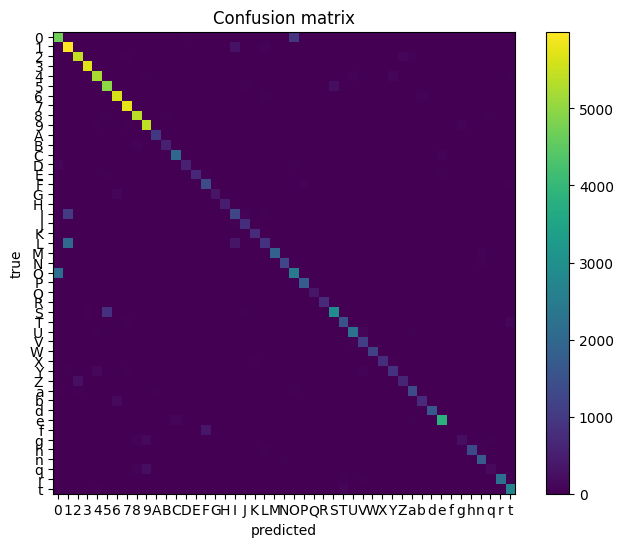

Accuracy:  0.8142
Precision: 0.8523
Recall:    0.8142
F1-score:  0.8211


In [ ]:
#@title Quality
y_pred_tensor = get_conf_mat_onnx(ort_session)
confmat = ConfusionMatrix( task='multiclass', num_classes=len(class_names))
confmat_tensor = confmat(preds=y_pred_tensor,
                        target=test_data.targets)
draw_conf_tensor(confmat_tensor)
print_metrics(class_names, y_pred_tensor)

100%|██████████| 3/3 [08:55<00:00, 178.40s/it]



Train time on cuda: 535.404 seconds


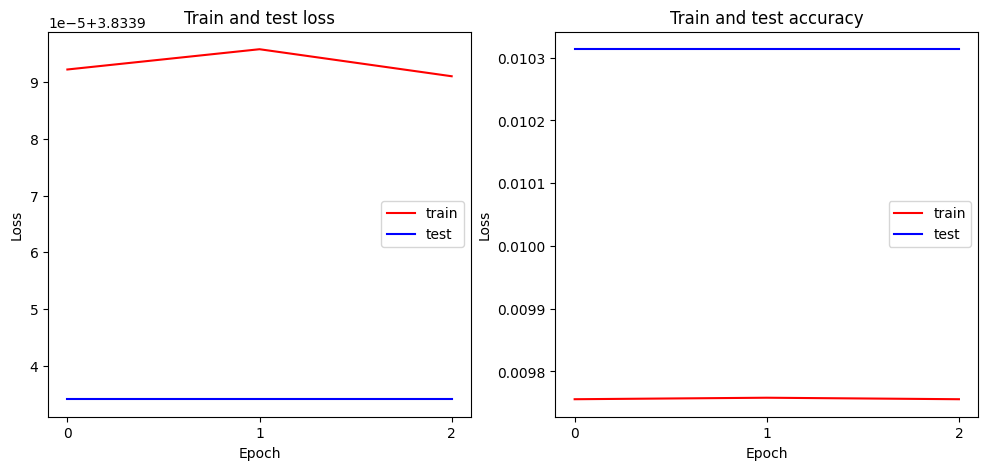

In [ ]:
#@title Train (very slow, better load pretrained)


student1 = MLPStudent().to(device)
train_model(model=student1,
            epochs=3,
            train_dataloader=train_dataloader,
            test_dataloader=test_dataloader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            accuracy_fn=accuracy_fn,
            device=device)
